# Final ML Project - Income Classification

This notebook is dedicated to the final project of the [Machine Learning Challenge](https://radu-enuca.gitbook.io/ml-challenge/), organised by ING.

The project is in the form of a Kaggle competition, where the notebook that you are currently reading serves as my final product that I will submit for the competition. More info about the kaggle competition can be found [here](https://www.kaggle.com/c/ml-challenge-week6).

The competition concerns an income classification challenge. We are given two sets of data from the US census bureau database: a train set and a test set. The sets contain demographic and job related information about the US population in the years 1994 and 1995. The train set contains a column representing the income class (>50k, <50k), but the test set has not. It is our task to predict the income classes of all the records in the test set. The predictions submitted to the kaggle competition are going to be evaluated based on the [Area Under the Curve (AUC) of the ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

Our analysis will be organised as follows:
1. Loading the data
2. Exploratory analysis
3. Data preprocessing
4. Model fitting
5. Final predictions

## 1. Loading the data

In [5]:
# First we import our packages, in descending order of their length (OCD)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import plot_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np

If you are running this on Google Colab and you have access to the kaggle challenge, you can submit your Kaggle API key and load the data into the Google Colab session.

By inspecting the data a little bit in it's raw format, we observe a few things:
The data in the file is separated by a comma, sometimes followed by or starting with some whitespaces. To allow for the whitespaces, we use a regular expression as a separator: ' \*, \*' (an asterisk indicates zero or more occurrences of the preceding element). It appears that missing values are represented by a '?' (and 'Do not know' in one particular column), so we need to tell python to interpret these values as missing. We also see the value "Not in universe" a lot, but I'm not yet sure what to do with this as it has a different meaning compared to a missing value. So we leave it in for now. (See https://cps.ipums.org/cps-action/faq#ques8). Also, we are able to retrieve a full list of the column names from the file census-income.names:

In [17]:
# Read in the data
census = pd.read_csv('ml-challenge-week6/census-income.data',
                     sep=' *, *',
                     header=None,
                     na_values=['?', 'Do not know'],
                     engine='python')

colnames_read = pd.read_csv('ml-challenge-week6/census-income.names',
                            sep=' *: *',
                            header=None,
                            skiprows=141,
                            usecols=[0], engine='python')
colnames = colnames_read.drop([24]).append(['income'], ignore_index=True).values.ravel()
census.columns = colnames
# The column 'instance weight' is not a feature, but it shows how many people in the sample this record represents due
# to stratified sampling. We don't need it for modelling so we drop it immediately.
census = census.drop(columns='instance weight')
print(census.shape)
census.info()

(199523, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199523 non-null  int64 
 1   class of worker                             199523 non-null  object
 2   detailed industry recode                    199523 non-null  int64 
 3   detailed occupation recode                  199523 non-null  int64 
 4   education                                   199523 non-null  object
 5   wage per hour                               199523 non-null  int64 
 6   enroll in edu inst last wk                  199523 non-null  object
 7   marital stat                                199523 non-null  object
 8   major industry code                         199523 non-null  object
 9   major occupation code                       199523 non-null  object


Cool! The dataset contains our target variable (which we named income) and 40 features. For a model, 40 features is probably a bit of an overkill, so let's see how much is actually useful to us. From the table above we can already see that we have both numeric and categorical variables. In total we have 199.523 observations and all our numerical variables are completely filled (so no null values). 

Unfortunately this doesn't seem to be the case for our categorical variables. Especially the migration variables seem
to be missing a lot of observations, so we will probably get rid of them.

## 2. Exploratory analysis

Luckily our variable of interest does not have any missing values. Let's quickly check it's distribution:

- 50000.    187141
50000+.      12382
Name: income, dtype: int64

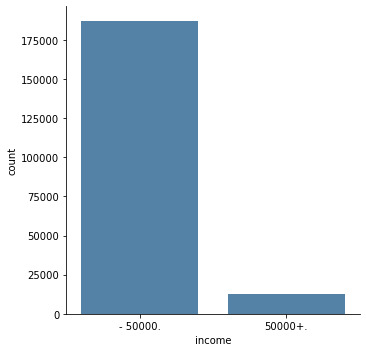

In [18]:
sns.catplot(x="income", kind="count", color='steelblue', data=census)
census['income'].value_counts()

So only about **7%** of our sample has an income class >50k. For modelling purposes we might consider balancing our
sample, but we will come to that later. First, let's go through some of our features to get a better understanding
of what we are dealing with. As we have quite a lot of variables in our dataset, we will first focus on a few
promising ones.

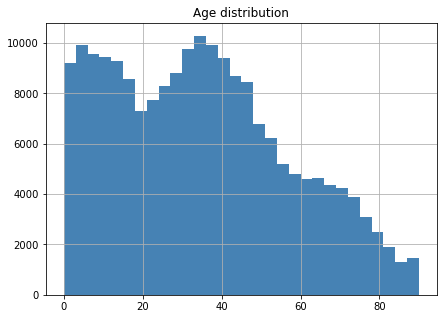

In [19]:
plt.figure(figsize=(7, 5))
census['age'].hist(bins=30, color='steelblue')
plt.title('Age distribution')
plt.show()

Interesting! It looks like we have a sample of the whole population, including children.
Children from a certain age are not allowed in the workplace by federal child labor law.

In [20]:
census[census['income'] == '50000+.'].loc[:, ['age']].describe()

,age
count,12382.000000
mean,46.266193
std,11.830906
min,16.000000
25%,38.000000
50%,45.000000
75%,53.000000
max,90.000000


Indeed, the minimum age of someone who earns more than 50k is 16. We might choose to exclude these children from our
model, as we know with certainty that they fall in the lower income class. However, I think it's nice to see whether
our model will be able to pick this up. So we are going to use it to check our final predictions.

Let's quickly plot a few of our numeric variables against each other. However, as we have quite a lot of data this is computationally intensive. To this end, we create a subsample, which we only use for exploratory analysis

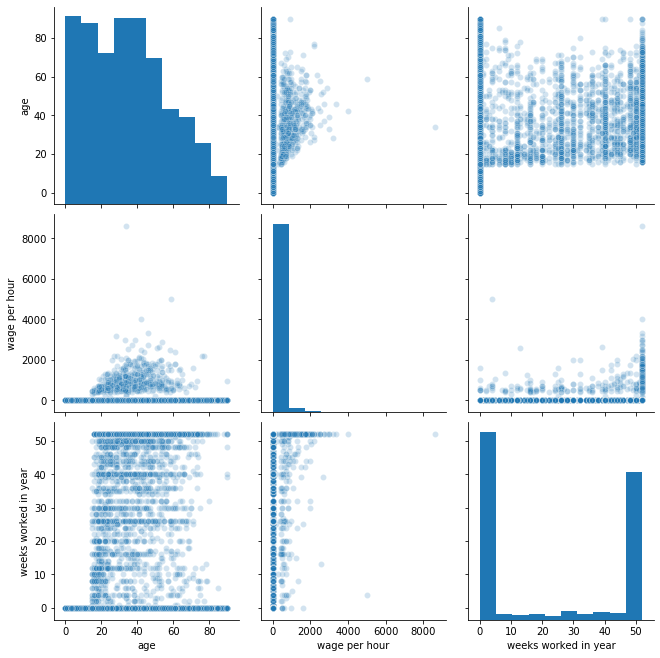

In [21]:
rand_sample = census.sample(n=10000, random_state=24)

sns.pairplot(rand_sample[['age', 'wage per hour', 'weeks worked in year']],
             kind="scatter",
             plot_kws={'alpha': 0.2},
             height=3,
             aspect=1)

Moreover, the variables 'capital losses', 'capital gains' and 'dividends from stocks' might directly say something about the income of a person (depending oon the definition of income), so let's look at those variables:

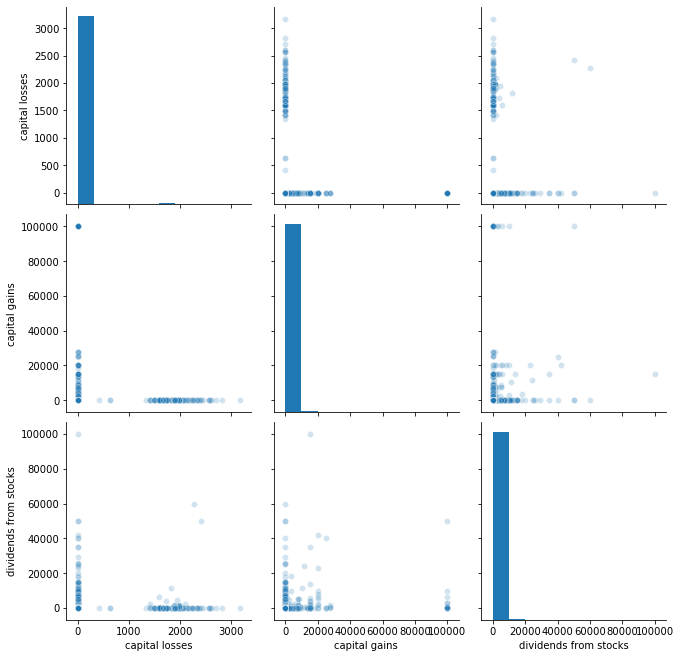

In [22]:
sns.pairplot(rand_sample[['capital losses', 'capital gains', 'dividends from stocks']],
             kind="scatter",
             plot_kws={'alpha': 0.2},
             height=3,
             aspect=1)

It looks like 'capital gains' and 'dividends from stocks' are topcoded or something. Actually I like to further inspect this with all the data:

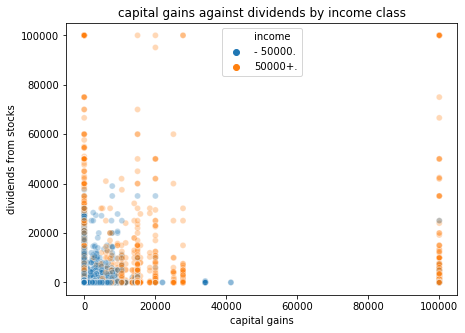

In [23]:
plt.figure(figsize=(7, 5))
sns.scatterplot(census['capital gains'],
                census['dividends from stocks'],
                hue=census['income'],
                alpha=0.3)
plt.title('capital gains against dividends by income class')
plt.show()

The first thing that we notice from this figure is that for capital gains the value 99999 occurs quite frequently, even though there are no instances before that until roughly 40,000. So this suggests that the value 99999 has a special meaning. Indeed, this value is equivalent to "Not in Universe", as can be found from the [Current Population Survey](https://cps.ipums.org/cps-action/variables/CAPGAIN#codes_section), where the data is extracted from. We don't want to keep these values, as it messes with the distribution, so we will probably replace these values with the median value. It is however curious that almost all of them fall in the income class >50k, but that must be due to another reason. Perhaps our model will be able to explain that:)

The column 'dividends from stocks' also has a max value of 99999, but here the data is actually topcoded (censured from above) and we decide to keep it as is (found [here](https://cps.ipums.org/cps/topcodes_tables.shtml)).

There are a few variables that actually say something about the type of work that someone is doing.

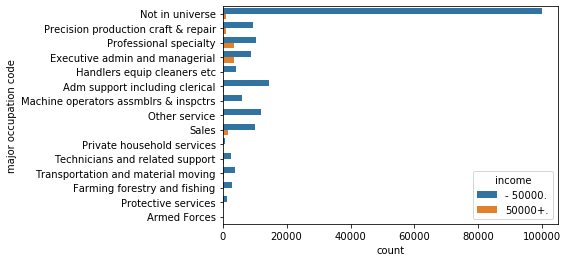

In [24]:
sns.countplot(y='major occupation code', hue='income', data=census)

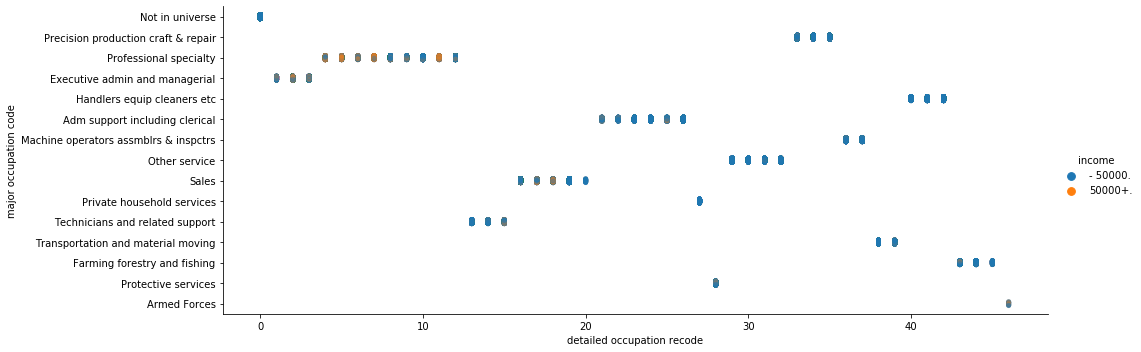

In [25]:
sns.catplot(x='detailed occupation recode',
            y='major occupation code',
            data=census[census['age'] >= 16],
            hue='income',
            alpha=0.3,
            height=5,
            aspect=3)

From this plot we can see that major occupation code is actually a grouping of 'detailed occupation recode'. So we will not include them both in our model, as they are highly correlated. In the same way, major industry code is a grouping of detailed industry recode. So we are not going to include them both in our model, but we might transform them into dummies and select a few on them based on some criteria (like chi squared test).

## Data preprocessing

Normally, this is the point where we would split our data in a train and test set, where we would not touch our test set until we selected our final model. However, in this case we already have our test set, namely the one for which we need to predict the income class. However, to test our model parameters we need a train/validation split as well. We will validate our result through Kfold cross-validation, using the AUC of the ROC as our score (as this will be the performance measure for the kaggle competition). The 'cross_val_score' function from sklearn.model_selection only allows (to my knowledge) for the roc_auc based on the predicted probabilities and not based on the predicted values (0 or 1). It would be nice to do a cross validation based on the predicted values, as this would be the reflect the performance measure of the kaggle challenge the most. Luckily we learned to write our own functions in the first week of the MLC, so let's put this in practice:

In [62]:
def cv_kaggle(model, x, y, cv, state):
    """
    This function performs a cross-validation of a specific model and returns an array of roc_auc scores.
    The roc_auc values are calculated based on the predicted values and not the predicted probabilities.
    It splits the sample in a train and validation set for a specified (cv) number of times. Each sample will
    be in a validation set exactly once.

    :param model: statistical model to be validated
    :param x: DataFrame with features
    :param y: DataFrame with target variable
    :param cv: integer specifying the number of k-fold cross validation
    :param state:
    :return: array with all the roc_auc scores of each split
    """

    # First shuffle the dataset, because the input dataset might be sorted (for instance, as a result of balancing)
    reshuffle_all = x.join(y).sample(frac=1, random_state=state).reset_index(drop=True)
    x = reshuffle_all.iloc[:, :-1]
    y = reshuffle_all.iloc[:, -1]

    result = [None] * cv
    max_row = x.shape[0] - 1
    low = 0
    high = round(max_row / cv)
    for i in range(cv):
        test = range(low, high)
        x_loop_train, x_loop_test, y_loop_train, y_loop_test = x.drop(test), x.iloc[test], y.drop(test), y.iloc[test]
        model.fit(x_loop_train, y_loop_train.values.ravel())
        y_loop_pred = np.round(model.predict(x_loop_test))
        result[i] = roc_auc_score(y_loop_test, y_loop_pred)
        low = high
        high = round(max_row / cv * (i + 2))
    return result


Using the function above we are going to test the models that we are going to fit during the next part of our analysis. But first we have to:
- Preprocess our data so that it can be used in our models, and
- Decide which features to include in our model. 

In [29]:
# First, encode our income variable into a binary 0/1 variable instead of having string values
enc_income = LabelEncoder()
census.loc[:, ['income']] = enc_income.fit_transform(census['income'])

#Let's seperate our data into features and label:
X = census.drop(columns=['income'])
y = pd.DataFrame(census['income'])

Now, the following code is the result of an iterative process of including and excluding the variables and see whether the model performance improved. Here we experimented with different treatments of missing values and the value "Not in universe". As a result we decided to drop the following columns, where the reason for it is written behind the column name.

In [30]:
drop_columns = ['migration code-change in msa',  # Too many missing
                'migration code-change in reg',  # Too many missing
                'migration code-move within reg',  # Too many missing
                'migration prev res in sunbelt',  # Too many missing
                'detailed occupation recode',  # Already used on grouped level
                'detailed industry recode',  # Already used on grouped level
                'enroll in edu inst last wk',  # Too many in "Not in universe"
                'member of a labor union',  # Too many in "Not in Universe"
                'reason for unemployment',  # Too many in "Not in Universe"
                'region of previous residence',  # Too many in "Not in Universe"
                'state of previous residence',  # Too many in "Not in Universe"
                'detailed household and family stat',  # Too many categories/detail, we use higher level summary
                'family members under 18',  # Too many in "Not in Universe"
                "fill inc questionnaire for veteran's admin"]  # Too many in "Not in Universe"

X = X.drop(columns=drop_columns)

Now, for the categorical variables that are still in our dataset and have some missing numbers, we decided to replace the missing values with the most frequent number. The 'most_frequent' strategy of the SimpleImputer transformer of sklearn actually seemed a bit slow. So to this end we will write our own functions that we can apply later to our test set as well. This is probably not the most elegant way to do it, but it works for now.

In [31]:
# get the modes for the ones that we are going to fill
mode_hisp = X['hispanic origin'].value_counts().index[0]
mode_birth_self = X['country of birth self'].value_counts().index[0]
mode_birth_mom = X['country of birth mother'].value_counts().index[0]
mode_birth_dad = X['country of birth father'].value_counts().index[0]


def fill_na_cats(x):
    x.loc[:, ['hispanic origin']] = x['hispanic origin'].fillna(mode_hisp)
    x.loc[:, ['country of birth self']] = x['country of birth self'].fillna(mode_birth_self)
    x.loc[:, ['country of birth mother']] = x['country of birth mother'].fillna(mode_birth_mom)
    x.loc[:, ['country of birth father']] = x['country of birth father'].fillna(mode_birth_dad)
    return x

Next, we will experiment with grouping some of our values in our categorical variables, to reduce the number of dummies that we are going to produce. We again do this with a function (if we had more time, we would probably try to do this with a transformer object as well, which would work well with the pipelines that we are going to create later on)

In [32]:
class DefaultZero(dict):
    def __missing__(self, key):
        return 0


def group_cats(x):
    x['education'] = x['education'] \
        .replace(to_replace='.*grade.*', value='Still in high school', regex=True) \
        .replace(to_replace='.*Associates degree.*', value='Some college', regex=True) \
        .replace(to_replace='Some college but no degree', value='Some college', regex=True)

    map_race = {
        'White': 1,
        'Black': 0,
        'Asian or Pacific Islander': 0,
        'Other': 0,
        'Amer Indian Aleut or Eskimo': 0
    }

    x['race'] = x['race'].map(map_race)

    map_hisp = {
        'All other': 0,
        'Mexican (Mexicano)': 1,
        'Mexican-American': 1,
        'Puerto Rican': 1,
        'Central or South American': 1,
        'Other Spanish': 1,
        'Chicano': 1,
        'Cuban': 1
    }
    x['hispanic origin'] = x['hispanic origin'].map(map_hisp)

    map_birth = DefaultZero({'United-States': 1})
    x['country of birth self'] = x['country of birth self'].map(map_birth)
    x['country of birth father'] = x['country of birth father'].map(map_birth)
    x['country of birth mother'] = x['country of birth mother'].map(map_birth)
    return x

Now apply our functions to the dataset:

In [33]:
X = fill_na_cats(X)
X = group_cats(X)

Next, we are going to create a pipeline for the rest of our transformations.
We start with our 6 numerical variables. We are going to use SimpleImputer to replace our 99999 values in 'capital gains' with the median value (as discussed in the previous section). Next, we are going to standardize all our numerical values with the StandardScalar. For some models (among which the logit model) this resulted in a better performance.

In [34]:
var_num = ['age',
           'wage per hour',
           'capital gains',
           'capital losses',
           'dividends from stocks',
           'weeks worked in year']

var_cat = X.drop(columns=var_num).columns.values.tolist()

NumImputer = ColumnTransformer([
    ("gains_imputer", SimpleImputer(missing_values=99999, strategy='median'), ['capital gains'])
], remainder=SimpleImputer(strategy='median'))

num_pipeline = Pipeline([
    ('imputer', NumImputer),
    ('std_scaler', StandardScaler()),
])


In the same way we are going to add our categorical variables to the pipeline, using OneHotEncoder:

In [35]:
var_cat_label = ['sex',
                 'race',
                 'hispanic origin',
                 'country of birth self',
                 'country of birth father',
                 'country of birth mother',
                 'year']

var_cat_onehot = X.drop(columns=var_num).drop(columns=var_cat_label).columns.values

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, var_num),
    ("cat", OneHotEncoder(sparse=False), var_cat_onehot),
    ("sex", OneHotEncoder(drop='first', sparse=False), var_cat_label)
])


Now that we created our pipeline, we apply it to our dataset:

In [36]:
X = pd.DataFrame(full_pipeline.fit_transform(X))

As a final step in our feature selection procedure, we are going to do some univariate analysis in the form of an annova test for our numerical values and a chi-squared test for our categorical values.

In [37]:
def univariate_test(x_data, y_data, score, k):
    fs = SelectKBest(score_func=score, k=k)
    fs.fit(x_data, y_data)
    df_scores = pd.DataFrame(fs.scores_)
    df_pvalues = pd.DataFrame(fs.pvalues_)
    df_columns = pd.DataFrame(x_data.columns)
    df_fs = pd.concat([df_columns, df_scores, df_pvalues], axis=1)
    df_fs.columns = ['Specs', 'Score', 'p-value']
    df_fs_sort = df_fs.sort_values('Score', ascending=False).reset_index(drop=True)
    return df_fs_sort


fs_num = univariate_test(X.iloc[:, 0:6], y.values.ravel(), score=f_classif, k='all')
fs_cat = univariate_test(X.iloc[:, 6:], y.values.ravel(), score=chi2, k='all')

In [41]:
fs_num

,Specs,Score,p-value
0,0,17832.231168,0.000000e+00
1,5,14743.486908,0.000000e+00
2,4,6361.441754,0.000000e+00
3,3,4432.270493,0.000000e+00
4,1,3744.148261,0.000000e+00
5,2,120.110687,6.093672e-28


All of the numeric features have a statistically significant effect, so we leave them in our model

In [44]:
fs_cat[95:]

,Specs,Score,p-value
95,55,15.865715,0.000068
96,92,11.650554,0.000642
97,78,9.274679,0.002323
98,14,8.888856,0.002869
99,57,6.779592,0.009221
100,86,6.731474,0.009473
101,115,6.041224,0.013976
102,103,3.541628,0.059847
103,84,3.109709,0.077827
104,105,2.649995,0.103550


For the categorical variables there are definitely a few which do not have a statistically significant effect. We choose to remove the ones that do not have an effect at a 1% level of significance (so from row 101)

In [45]:
drop = fs_cat.loc[101:, 'Specs'].values 
X = X.drop(columns=drop)

Moreover, when we try PCA to select the most important features, it did not improve our model. For every feature we removed, the worse our model performed with respect to our kaggle performance function. If you want to experiment with this yourselve, we have added the code in the comments:

In [ ]:
# pca = PCA()
# pca.fit_transform(X)
# features = range(pca.n_components_)
# plt.bar(features, pca.explained_variance_)
# X = pd.DataFrame(pca.transform(X))

## 3. Model fitting

Now that we have our preprocessed data, we want to fit a model. As we noticed during our exploratory analysis, we have a highly unbalanced sample. We have far more data points for the lower income class as compared to the higher income class. A result of this skewed data could be that a correct classification of the lower income class is worth more than a correct classification of the higher income class, which should not be the case! So to deal with this issue we rebalance our sample:

In [53]:
# Balanced sample

y['income'].value_counts()
Xy = X.join(y)
over_50 = Xy.loc[Xy["income"] == 1]
under_50 = Xy.loc[Xy["income"] == 0]
under_50_new = under_50.sample(len(over_50), random_state=25)

We should check the representativeness of the smaller sample compared to the larger one (let's do this only for the numerical variables)

In [50]:
under_50.iloc[:,:6].describe()

,0,1,2,3,4,5
count,187141.000000,187141.000000,187141.000000,187141.000000,187141.000000,187141.000000
mean,-0.073677,-0.034910,-0.006309,-0.037919,-0.045215,-0.067474
std,0.564094,1.013868,0.950063,0.844202,0.458519,0.987988
min,-0.146912,-1.546074,-0.201629,-0.137236,-0.099553,-0.949346
25%,-0.146912,-0.918576,-0.201629,-0.137236,-0.099553,-0.949346
50%,-0.146912,-0.156614,-0.201629,-0.137236,-0.099553,-0.949346
75%,-0.146912,0.650168,-0.201629,-0.137236,-0.099553,1.180804
max,25.219094,2.487840,35.870226,16.810437,19.556133,1.180804


In [51]:
under_50_new.iloc[:,:6].describe()

,0,1,2,3,4,5
count,12382.000000,12382.000000,12382.000000,12382.000000,12382.000000,12382.000000
mean,-0.081797,-0.030227,0.003189,-0.043726,-0.053502,-0.061392
std,0.496497,1.012270,1.088378,0.832141,0.412319,0.988376
min,-0.146912,-1.546074,-0.201629,-0.137236,-0.099553,-0.949346
25%,-0.146912,-0.918576,-0.201629,-0.137236,-0.099553,-0.949346
50%,-0.146912,-0.111793,-0.201629,-0.137236,-0.099553,-0.949346
75%,-0.146912,0.650168,-0.201629,-0.137236,-0.099553,1.180804
max,12.165211,2.487840,35.448247,16.810437,17.540165,1.180804


It seems representative, so we use this to form our balanced dataset:

In [54]:
# balanced sample:
Xy_b = pd.concat([over_50, under_50_new])
X_b = Xy_b.drop(columns=['income'])
y_b = Xy_b['income']

Now that we have our balanced dataset, we can fit and compare different models. Let's start with a logit model:

In [57]:
# logit
logit = LogisticRegression(solver='liblinear', random_state=24)
logit.fit(X_b, y_b)
y_pred = logit.predict(X_b)
roc_auc_score(y_b, y_pred)

0.8727992246809885

Not bad at all! Now, let's see our tailor made cross-validation function in action:

In [58]:
scores = cv_kaggle(logit, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.870214
std,0.005258
min,0.865956
25%,0.866256
50%,0.869200
75%,0.870759
max,0.878901


All looks good! The score is actually above the ML Solution on the kaggle leaderboard. At this point I submitted my predictions (using this model) to the kaggle competition to see how it was going to be evaluated. And indeed the score was very similar. So it is good to know we can trust our performance measure:)

It's Hyperparameter time! Let's perform a randomized grid search to find the best hyperparameters:

In [60]:
param_grid = {'C': np.logspace(0, 10, 10),
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']
              }
logit_search = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=24),
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    refit=True,
    return_train_score=True
)
logit_search.fit(X_b, y_b)
logit_search.best_estimator_.get_params()
logit_best = logit_search.best_estimator_
pred_logit_best = logit_search.predict(X_b)
roc_auc_score(y_b, pred_logit_best)
scores = cv_kaggle(logit_best, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.870295
std,0.005165
min,0.865954
25%,0.867471
50%,0.868790
75%,0.870155
max,0.879104


Unfortunately, not a great performance improvement

Let's compare a few other models:

In [63]:
# Regression tree
tree_reg = DecisionTreeRegressor(random_state=25)
tree_reg.fit(X_b, y_b)
y_pred_tree = tree_reg.predict(X_b)
roc_auc_score(y_b, y_pred_tree)

# cross-validation
scores = cv_kaggle(tree_reg, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.814725
std,0.008085
min,0.801931
25%,0.812192
50%,0.816917
75%,0.820905
max,0.821681


In [64]:
# Random forest regression
forest_reg = RandomForestRegressor(random_state=25)
forest_reg.fit(X_b, y_b)
y_pred_forest = forest_reg.predict(X_b)
roc_auc_score(y_b, y_pred_forest)

# cross-validation
scores = cv_kaggle(forest_reg, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.861712
std,0.005554
min,0.856362
25%,0.858998
50%,0.859768
75%,0.862622
max,0.870812


In [65]:
# Forest classifier
forest_class = RandomForestClassifier(random_state=25)
forest_class.fit(X_b, y_b)
y_pred_forest_c = forest_class.predict(X_b)
roc_auc_score(y_b, np.round(y_pred_forest_c))

# cross-validation
scores = cv_kaggle(forest_class, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.867275
std,0.003454
min,0.862766
25%,0.866044
50%,0.866598
75%,0.868938
max,0.872032


In [66]:
# GNB
gnb = GaussianNB()
gnb.fit(X_b, y_b)
y_pred_gnb = gnb.predict(X_b)
roc_auc_score(y_b, np.round(y_pred_gnb))

# cross-validation
scores = cv_kaggle(gnb, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.812784
std,0.005092
min,0.808273
25%,0.808601
50%,0.810840
75%,0.816445
max,0.819763


In [67]:
# GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(X_b, y_b)
y_pred_gb = gb.predict(X_b)
roc_auc_score(y_b, np.round(y_pred_gb))

# cross-validation
scores = cv_kaggle(gb, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.873410
std,0.002285
min,0.870971
25%,0.871032
50%,0.874127
75%,0.875047
max,0.875875


In [68]:
# SVC
svc = svm.SVC()
svc.fit(X_b, y_b)
y_pred_svc = svc.predict(X_b)
roc_auc_score(y_b, np.round(y_pred_svc))

# cross-validation
scores = cv_kaggle(svc, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.873046
std,0.003068
min,0.871222
25%,0.871579
50%,0.871949
75%,0.871975
max,0.878508


In [69]:
# XGB Classifier
xgb = XGBClassifier()
xgb.fit(X_b, y_b)
y_pred_xgb = xgb.predict(X_b)
roc_auc_score(y_b, y_pred_xgb)
# xgb.feature_importances_
# plot_importance(xgb)

scores = cv_kaggle(xgb, X_b, y_b, cv=5, state=24)
pd.DataFrame(scores).describe()

,0
count,5.000000
mean,0.878380
std,0.006377
min,0.871711
25%,0.873927
50%,0.878126
75%,0.879969
max,0.888167


It looks like we have a winner! With an auc_roc of about 87,8% the XBG Classifier looks the best model. Just like we did with the logit model we have optimized the parameters uzing a randomized grid search, but unfortunately without an improvement in performance.

## Final Predictions
Now that we have estimated a model to predict income class, we are going to apply it on the test dataset for the kaggle competition. But first we need to load and preprocess the data before we can apply our model:

In [70]:
kaggle_test = pd.read_csv('ml-challenge-week6/census-income.test',
                          sep=' *, *',
                          header=None,
                          na_values=['?', 'Do not know'],
                          engine='python',
                          names=colnames[0:-1]
                          )

kaggle_clean = kaggle_test.drop(columns=drop_columns)
kaggle_clean = fill_na_cats(kaggle_clean)
kaggle_clean = group_cats(kaggle_clean)
kaggle_clean = pd.DataFrame(full_pipeline.transform(kaggle_clean))
kaggle_clean = kaggle_clean.drop(columns=drop)


c:\users\jjlam\documents\1_projects\pycharm\mlc\venv\lib\site-packages\sklearn\compose\_column_transformer.py:427: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


We thank sklearn for the warning, but in this case it's okay!
Now, before we can make our predictions, I noticed some sort of "bug" in XGBClassifier. Apperently this model object saves numerical columns as strings with additional whitespaces. So we get an error if we predict with new data. We solve this by manually renaming the feature names:

In [71]:
feature_names = [i.strip() for i in xgb.get_booster().feature_names]
xgb.get_booster().feature_names = feature_names

Now we can make our final predictions and submit them to kaggle!

In [73]:
kaggle_pred = xgb.predict(kaggle_clean)
kaggle_test['income class'] = np.round(kaggle_pred)
submission = kaggle_test['income class']
submission.to_csv('submission.csv', sep=',', index_label='index')

# Submission done locally via pc
# os.system('kaggle competitions submit -c ml-challenge-week6 -f W6/submission.csv -m "XGB"')

## Final words

Unfortunately, this submission marks the end of the Machine Learning Challenge. During the last 6 weeks I definitely learned a lot and I am greatful that this course was made available by ING. I really liked the organisation and structure of the course, so many thanks to the organisers!!!

Stay healty and keep coding!